# July 28, August 1,3,8,15-16, 2022: create new set of rois from center coordinates

- August 15, 2022: rename Mashid rois according to MAX rois
- August 16, September 12, 2022: add subcortical rois in the roi mask and generate trial level responses

The previous code did not get saved, so doing again on August 3, 2022.

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random

from nltools import mask
from nilearn import image, masking, plotting

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/aug22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## set of rois

### roi names file

In [2]:
set_name = 'mashid'
mask_dir = f"{proj_dir}/data/rois/{set_name}/individual_nifti_files"
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"

roi_set_df = pd.read_csv(roi_set_file)
def str_to_list(s): 
    a = s.strip('][').split(', ')
    if len(a) == 3:
        return list(map(int, a))
    else:
        return []
roi_set_df['coordinates'] = roi_set_df['coordinates'].apply(str_to_list)

In [3]:
'''
Salience
'''
roi_set_df.at[0,  'roi_name'] = 'L mid/post Insula'
roi_set_df.at[1, 'roi_name'] = 'R mid/post Insula'
roi_set_df.at[2, 'roi_name'] = 'R post. MCC'
roi_set_df.at[3, 'roi_name'] = 'L TPJ'
roi_set_df.at[4, 'roi_name'] = 'R TPJ'
roi_set_df.at[5, 'roi_name'] = 'L ITC'
roi_set_df.at[6, 'roi_name'] = 'R ITC'
roi_set_df.at[7, 'roi_name'] = 'L Precentral'
roi_set_df.at[8, 'roi_name'] = 'R Precentral'
roi_set_df.at[9, 'roi_name'] = 'L dlPFC'
roi_set_df.at[10, 'roi_name'] = 'R dlPFC'
roi_set_df.at[11, 'roi_name'] = 'L IFG-1'
roi_set_df.at[12, 'roi_name'] = 'R IFG-6'

'''
Executive
'''
roi_set_df.at[13, 'roi_name'] = 'L orbit. front. Insula'
roi_set_df.at[14, 'roi_name'] = 'R MFG-1'
roi_set_df.at[15, 'roi_name'] = 'L MFG-1'
roi_set_df.at[16, 'roi_name'] = 'R MOG'
roi_set_df.at[17, 'roi_name'] = 'L MOG'
roi_set_df.at[18, 'roi_name'] = 'R IFG-6'
roi_set_df.at[19, 'roi_name'] = 'R MFG-2'
roi_set_df.at[20, 'roi_name'] = 'L MFG-2'
roi_set_df.at[21, 'roi_name'] = 'dmPFC'
roi_set_df.at[22, 'roi_name'] = 'R lat. PC'
roi_set_df.at[23, 'roi_name'] = 'L lat. PC'
roi_set_df.at[24, 'roi_name'] = 'R ITG'

'''
Task-negative
'''
roi_set_df.at[25, 'roi_name'] = 'L post. MCC'
roi_set_df.at[26, 'roi_name'] = 'Retro-splenial'
roi_set_df.at[27, 'roi_name'] = 'L Angular Gyrus'
roi_set_df.at[28, 'roi_name'] = 'R Angular Gyrus'
roi_set_df.at[29, 'roi_name'] = 'M vmPFC1'
roi_set_df.at[30, 'roi_name'] = 'L SMG'
roi_set_df.at[31, 'roi_name'] = 'L SFG'
roi_set_df.at[32, 'roi_name'] = 'R SFG'
roi_set_df.at[33, 'roi_name'] = 'L ITG'
roi_set_df.at[34, 'roi_name'] = 'R MTG'
roi_set_df.at[35, 'roi_name'] = 'L para Hippocampus'
roi_set_df.at[36, 'roi_name'] = 'R para Hippocampus'

'''
Subcortical
'''
roi_set_df.at[37, 'roi_name'] = 'L CeMe Amygdala'
roi_set_df.at[38, 'roi_name'] = 'R CeMe Aymgdala'
roi_set_df.at[39, 'roi_name'] = 'L BLBM Amygdala'
roi_set_df.at[40, 'roi_name'] = 'R BLBM Amygdala'
roi_set_df.at[41, 'roi_name'] = 'L PAG'
roi_set_df.at[42, 'roi_name'] = 'R PAG'
# roi_set_df.at[43, 'roi_name'] = 'L Habenula'
# roi_set_df.at[44, 'roi_name'] = 'R Habenula'
roi_set_df.at[43, 'roi_name'] = 'L BST'
roi_set_df.at[44, 'roi_name'] = 'R BST'

In [4]:
'''
Salience
'''
roi_set_df.at[0,  'in_MAX'] = True
roi_set_df.at[1, 'in_MAX'] = True
roi_set_df.at[2, 'in_MAX'] = True
roi_set_df.at[3, 'in_MAX'] = False
roi_set_df.at[4, 'in_MAX'] = False
roi_set_df.at[5, 'in_MAX'] = False
roi_set_df.at[6, 'in_MAX'] = False
roi_set_df.at[7, 'in_MAX'] = False
roi_set_df.at[8, 'in_MAX'] = False
roi_set_df.at[9, 'in_MAX'] = True
roi_set_df.at[10, 'in_MAX'] = True
roi_set_df.at[11, 'in_MAX'] = True
roi_set_df.at[12, 'in_MAX'] = True

'''
Executive
'''
roi_set_df.at[13, 'in_MAX'] = False
roi_set_df.at[14, 'in_MAX'] = False
roi_set_df.at[15, 'in_MAX'] = False
roi_set_df.at[16, 'in_MAX'] = False
roi_set_df.at[17, 'in_MAX'] = False
roi_set_df.at[18, 'in_MAX'] = True
roi_set_df.at[19, 'in_MAX'] = False
roi_set_df.at[20, 'in_MAX'] = False
roi_set_df.at[21, 'in_MAX'] = False
roi_set_df.at[22, 'in_MAX'] = False
roi_set_df.at[23, 'in_MAX'] = False
roi_set_df.at[24, 'in_MAX'] = False

'''
Task-negative
'''
roi_set_df.at[25, 'in_MAX'] = True
roi_set_df.at[26, 'in_MAX'] = False
roi_set_df.at[27, 'in_MAX'] = False
roi_set_df.at[28, 'in_MAX'] = False
roi_set_df.at[29, 'in_MAX'] = True
roi_set_df.at[30, 'in_MAX'] = False
roi_set_df.at[31, 'in_MAX'] = False
roi_set_df.at[32, 'in_MAX'] = False
roi_set_df.at[33, 'in_MAX'] = False
roi_set_df.at[34, 'in_MAX'] = False
roi_set_df.at[35, 'in_MAX'] = False
roi_set_df.at[36, 'in_MAX'] = False

'''
Subcortical
'''
roi_set_df.at[37, 'in_MAX'] = True
roi_set_df.at[38, 'in_MAX'] = True
roi_set_df.at[39, 'in_MAX'] = True
roi_set_df.at[40, 'in_MAX'] = True
roi_set_df.at[41, 'in_MAX'] = True
roi_set_df.at[42, 'in_MAX'] = True
# roi_set_df.at[43, 'in_MAX'] = False
# roi_set_df.at[44, 'in_MAX'] = False
roi_set_df.at[43, 'in_MAX'] = True
roi_set_df.at[44, 'in_MAX'] = True

In [5]:
roi_set_df.to_csv(roi_set_file, index=False)

In [6]:
display(roi_set_df)

,network,mashid_roi_name,coordinates,roi_name,in_MAX
0,Salience,Frontoinsular cortex L,"[-34, 18, 4]",L mid/post Insula,True
1,Salience,Frontoinsular cortex R,"[34, 22, 4]",R mid/post Insula,True
2,Salience,Dorsal anterior cingulate cortex,"[2, 10, 40]",R post. MCC,True
3,Salience,Temporo-parietal junction L,"[-62, -26, 36]",L TPJ,False
4,Salience,Temporo-parietal junction R,"[62, -26, 36]",R TPJ,False
5,Salience,Inferotemporal cortex L,"[-54, -62, -4]",L ITC,False
6,Salience,Inferotemporal cortex R,"[54, -54, -8]",R ITC,False
7,Salience,Precentral L,"[-26, -6, 64]",L Precentral,False
8,Salience,Precentral R,"[26, -2, 64]",R Precentral,False
9,Salience,Dorsolateral prefrontal cortex L,"[-38, 42, 24]",L dlPFC,True


### creating rois mask

In [ ]:
'''
cortical rois
'''
radius = 5 # mm
final_mask_file = f"{mask_dir}/../final_mask_cortical.nii.gz"
cortical_mask_file = final_mask_file
if not os.path.exists(final_mask_file):
    for idx, row in tqdm(roi_set_df.iterrows()):
        if len(row['coordinates']) != 3: continue

        prefix = f"{mask_dir}/{row['roi_name']}.nii.gz"
        if idx == 0:
            final_mask = mask.create_sphere(row['coordinates'], radius=radius)
        else:
            roi_mask = mask.create_sphere(row['coordinates'], radius=radius)

            # step1: find intersection
            intersect_mask = masking.intersect_masks(
                [image.binarize_img(final_mask), roi_mask],
                threshold=1,
                connected=False
            )

            # step2: remove intersection from the roi_mask
            roi_mask = image.math_img(
                f'img1 - img2',
                img1=roi_mask,
                img2=intersect_mask
            )

            # step3: then include the roi into final_mask
            final_mask = image.math_img(
                f'img1 + {idx+1}*img2',
                img1=final_mask,
                img2=roi_mask
            )
    final_mask.to_filename(final_mask_file)

else:
    final_mask = image.load_img(final_mask_file)

In [8]:
'''
subcortical:
taken from MAX rois
'''
max_rois_img = image.load_img(
    f"/home/govindas/parcellations/MAX_85_ROI_masks/MAX_ROIs_final_gm_85.nii.gz"
)
max_rois = max_rois_img.get_fdata()

# these are numbers in the mask, not indices, 
# so directly use them.
subcort_roi_max_idxs = [
    57, 56, # L, R CeMe Amygdala
    59, 58, # L, R BLBM Amygdala
    81, 80, # L, R PAG
    55, 54 # L, R BST
]

# roi indices
subcort_roi_mashid_idxs = list(range(37, 45))

'''
roi masks
'''
final_mask_file = f"{mask_dir}/../final_mask_subcortical.nii.gz"
subcortical_mask_file = final_mask_file
if not os.path.exists(final_mask_file):
    for i, mashid_idx in tqdm(enumerate(subcort_roi_mashid_idxs)):
        max_idx = subcort_roi_max_idxs[i]
        if max_idx is None: continue
        roi_mask = (max_rois == max_idx) * (mashid_idx+1)

        if i == 0: 
            final_mask = image.new_img_like(
                ref_niimg=final_mask,
                data=roi_mask,
                copy_header=False
            )
        else:
            roi_mask = image.new_img_like(
                ref_niimg=final_mask,
                data=roi_mask,
                copy_header=False
            )
            
            intersect_mask = masking.intersect_masks(
                [image.binarize_img(final_mask), image.binarize_img(roi_mask)],
                threshold=1,
                connected=False
            )

            roi_mask = image.math_img(
                f'img1 - {mashid_idx+1}*img2',
                img1=roi_mask,
                img2=intersect_mask
            )

            final_mask = image.math_img(
                f'img1 + img2',
                img1=final_mask,
                img2=roi_mask
            )
    final_mask.to_filename(final_mask_file)
else:
    final_mask = image.load_img(final_mask_file)

0it [00:00, ?it/s]

array([ 0., 38., 39., 40., 41., 42., 43., 44., 45.])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.])

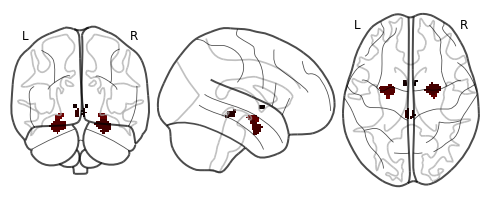

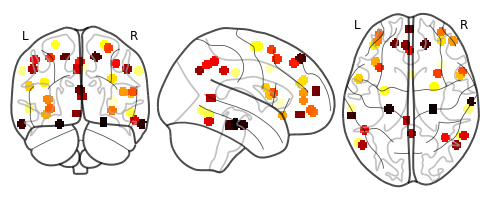

In [9]:
subcortical_mask = image.load_img(subcortical_mask_file)
display(np.unique(subcortical_mask.get_fdata()))
plotting.plot_glass_brain(subcortical_mask, threshold=0)

cortical_mask = image.load_img(cortical_mask_file)
display(np.unique(cortical_mask.get_fdata()))
plotting.plot_glass_brain(cortical_mask, threshold=0)

In [10]:
'''
combine cortical and subcortical masks
'''
final_mask_file = f"{mask_dir}/../final_mask_cortical+subcortical.nii.gz"
final_mask = image.math_img(
    f'img1 + img2',
    img1=cortical_mask_file,
    img2=subcortical_mask_file,
)
final_mask.to_filename(final_mask_file)

In [11]:
cort_subcort_mask = image.load_img(final_mask_file)
np.unique(cort_subcort_mask.get_fdata())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45.])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45.])

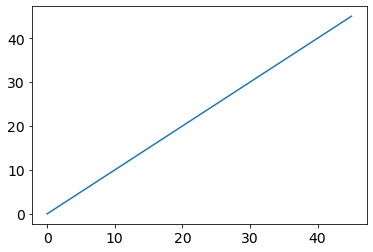

In [12]:
plt.plot(np.unique(final_mask.get_fdata()))

np.unique(final_mask.get_fdata())

individual rois may intersect if we simply add them to create a `final_mask`.
we avoid this by subtracting the intersection from the newly added roi and then adding the remaining of that roi in the `final_mask`.

the plot verifies that `final_mask` contains numbers only upto 47; number of rois, and individual rois do not intersect in the `final_mask`. 